In [2]:
from datasets import load_dataset

btc = load_dataset("wnut_17", trust_remote_code=True)
 # BTC is also referred to as WNUT17 NER
train_data = btc["train"]
valid_data = btc["validation"]
test_data = btc["test"]


Generating test split: 100%|██████████| 1287/1287 [00:00<00:00, 7293.07 examples/s] 


In [3]:
btc["train"][0]


{'id': '0',
 'tokens': ['@paulwalk',
  'It',
  "'s",
  'the',
  'view',
  'from',
  'where',
  'I',
  "'m",
  'living',
  'for',
  'two',
  'weeks',
  '.',
  'Empire',
  'State',
  'Building',
  '=',
  'ESB',
  '.',
  'Pretty',
  'bad',
  'storm',
  'here',
  'last',
  'evening',
  '.'],
 'ner_tags': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  8,
  8,
  0,
  7,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [4]:
btc["train"].features["ner_tags"].feature.names


['O',
 'B-corporation',
 'I-corporation',
 'B-creative-work',
 'I-creative-work',
 'B-group',
 'I-group',
 'B-location',
 'I-location',
 'B-person',
 'I-person',
 'B-product',
 'I-product']

In [5]:
# STEP 2: Understand the Structure
print("Sample Data:", train_data[0])
label_list = train_data.features['ner_tags'].feature.names
id2label = {i: l for i, l in enumerate(label_list)}
label2id = {l: i for i, l in enumerate(label_list)}

Sample Data: {'id': '0', 'tokens': ['@paulwalk', 'It', "'s", 'the', 'view', 'from', 'where', 'I', "'m", 'living', 'for', 'two', 'weeks', '.', 'Empire', 'State', 'Building', '=', 'ESB', '.', 'Pretty', 'bad', 'storm', 'here', 'last', 'evening', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0]}


In [6]:
# STEP 3: Tokenize & Align Labels using HuggingFace
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                # Use I- tags for subwords
                label_ids.append(label[word_idx] if label[word_idx] != 0 else 0)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

btc_tokenized = btc.map(tokenize_and_align_labels, batched=True)


Map: 100%|██████████| 1287/1287 [00:00<00:00, 3564.48 examples/s]


In [7]:
# STEP 4: Load Pretrained Token Classification Model
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

2025-04-22 14:46:59.995324: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install --use-pep517

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: You must give at least one requirement to install (see "pip help install")
Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install --use-pep517 seqeval


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached seqeval-1.2.2.tar.gz (43 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16250 sha256=ca78ce62a2618cac97a684d49df1d7b720b753a4f81cf705d352b897a4c556be
  Stored in directory: /Users/aryanlodha/Library/Caches/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install --upgrade setuptools pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached setuptools-79.0.0-py3-none-any.whl.metadata (6.5 kB)
Using cached setuptools-79.0.0-py3-none-any.whl (1.3 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 78.1.0
    Uninstalling setuptools-78.1.0:
      Successfully uninstalled setuptools-78.1.0
Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install seqeval


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [22]:
# STEP 5: Training Setup
from transformers import TrainingArguments, Trainer
import evaluate

metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)
    true_predictions = [
        [label_list[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]
    return metric.compute(predictions=true_predictions, references=true_labels)

args = TrainingArguments(
    output_dir="./ner_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=btc_tokenized["train"],
    eval_dataset=btc_tokenized["validation"],
    compute_metrics=compute_metrics
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
print(btc_tokenized.column_names)


{'train': ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'], 'validation': ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'], 'test': ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels']}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1009/1009 [00:00<00:00, 2303.04 examples/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/jt/0lv95mcn7f784lx7z_pw70tc0000gn/T/ipykernel_3830/1816800853.py:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Corporation,Creative-work,Group,Location,Person,Product,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,No log,0.341203,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 56}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 159}","{'precision': 0.21428571428571427, 'recall': 0.05172413793103448, 'f1': 0.08333333333333331, 'number': 58}","{'precision': 0.46835443037974683, 'recall': 0.38144329896907214, 'f1': 0.42045454545454536, 'number': 97}","{'precision': 0.6965648854961832, 'recall': 0.5236728837876614, 'f1': 0.5978705978705978, 'number': 697}","{'precision': 0.3333333333333333, 'recall': 0.005847953216374269, 'f1': 0.011494252873563218, 'number': 171}",0.651685,0.327948,0.436325,0.921778
2,No log,0.320292,"{'precision': 0.3508771929824561, 'recall': 0.35714285714285715, 'f1': 0.3539823008849557, 'number': 56}","{'precision': 0.125, 'recall': 0.012578616352201259, 'f1': 0.022857142857142857, 'number': 159}","{'precision': 0.21875, 'recall': 0.1206896551724138, 'f1': 0.15555555555555556, 'number': 58}","{'precision': 0.5327102803738317, 'recall': 0.5876288659793815, 'f1': 0.5588235294117647, 'number': 97}","{'precision': 0.7307001795332136, 'recall': 0.5839311334289814, 'f1': 0.6491228070175439, 'number': 697}","{'precision': 0.46153846153846156, 'recall': 0.14035087719298245, 'f1': 0.21524663677130043, 'number': 171}",0.629720,0.417609,0.502186,0.929769
3,0.181800,0.328085,"{'precision': 0.38636363636363635, 'recall': 0.30357142857142855, 'f1': 0.34, 'number': 56}","{'precision': 0.40625, 'recall': 0.08176100628930817, 'f1': 0.13612565445026178, 'number': 159}","{'precision': 0.16393442622950818, 'recall': 0.1724137931034483, 'f1': 0.16806722689075632, 'number': 58}","{'precision': 0.5428571428571428, 'recall': 0.5876288659793815, 'f1': 0.5643564356435643, 'number': 97}","{'precision': 0.7590361445783133, 'recall': 0.6327116212338594, 'f1': 0.6901408450704225, 'number': 697}","{'precision': 0.4935064935064935, 'recall': 0.2222222222222222, 'f1': 0.30645161290322576, 'number': 171}",0.640000,0.465267,0.538821,0.932312
4,0.181800,0.342173,"{'precision': 0.35294117647058826, 'recall': 0.32142857142857145, 'f1': 0.33644859813084116, 'number': 56}","{'precision': 0.38095238095238093, 'recall': 0.10062893081761007, 'f1': 0.1592039800995025, 'number': 159}","{'precision': 0.2033898305084746, 'recall': 0.20689655172413793, 'f1': 0.20512820512820515, 'number': 58}","{'precision': 0.5714285714285714, 'recall': 0.5773195876288659, 'f1': 0.5743589743589743, 'number': 97}","{'precision': 0.7564766839378239, 'recall': 0.6284074605451937, 'f1': 0.6865203761755486, 'number': 697}","{'precision': 0.47368421052631576, 'recall': 0.21052631578947367, 'f1': 0.29149797570850206, 'number': 171}",0.636464,0.465267,0.537564,0.933220


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 56}" of type <class 'dict'> for key "eval/corporation" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 159}" of type <class 'dict'> for key "eval/creative-work" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.21428571428571427, 'recall': 0.05172413793103448, 'f1': 0.08333333333333331, 'numbe

Trainer is attempting to log a value of "{'precision': 0.15671641791044777, 'recall': 0.15, 'f1': 0.1532846715328467, 'number': 140}" of type <class 'dict'> for key "eval/corporation" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.4852941176470588, 'recall': 0.13807531380753138, 'f1': 0.21498371335504884, 'number': 239}" of type <class 'dict'> for key "eval/creative-work" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.3333333333333333, 'recall': 0.1, 'f1': 0.15384615384615383, 'number': 250}" of type <class 'dict'> for key "eval/group" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.4972375690607735, 'recall': 0.4326923076923077, 'f1': 


Final Evaluation Metrics: {'eval_loss': 0.4190866947174072, 'eval_corporation': {'precision': 0.15671641791044777, 'recall': 0.15, 'f1': 0.1532846715328467, 'number': 140}, 'eval_creative-work': {'precision': 0.4852941176470588, 'recall': 0.13807531380753138, 'f1': 0.21498371335504884, 'number': 239}, 'eval_group': {'precision': 0.3333333333333333, 'recall': 0.1, 'f1': 0.15384615384615383, 'number': 250}, 'eval_location': {'precision': 0.4972375690607735, 'recall': 0.4326923076923077, 'f1': 0.4627249357326478, 'number': 208}, 'eval_person': {'precision': 0.7581521739130435, 'recall': 0.3263157894736842, 'f1': 0.45625511038430083, 'number': 855}, 'eval_product': {'precision': 0.30612244897959184, 'recall': 0.07211538461538461, 'f1': 0.11673151750972763, 'number': 208}, 'eval_overall_precision': 0.5291428571428571, 'eval_overall_recall': 0.24368421052631578, 'eval_overall_f1': 0.33369369369369367, 'eval_overall_accuracy': 0.9312445894652727, 'eval_runtime': 164.3703, 'eval_samples_per_s

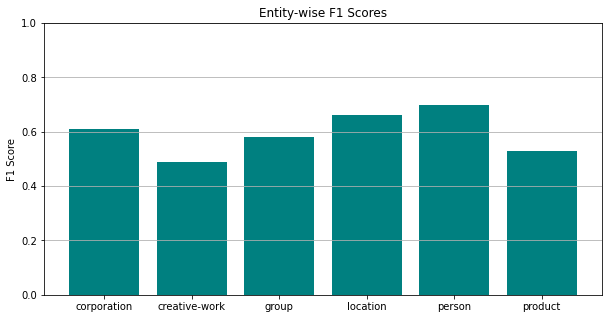

In [36]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
import evaluate
import torch
import matplotlib.pyplot as plt

# STEP 1: Load the BTC dataset
btc = load_dataset("wnut_17", trust_remote_code=True)
label_list = btc['train'].features['ner_tags'].feature.names
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}

# STEP 2: Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# STEP 3: Tokenization and label alignment
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], is_split_into_words=True, padding="max_length", truncation=True, max_length=36)
    labels = []

    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label[word_idx] != 0 else 0)
            previous_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

btc_tokenized = btc.map(tokenize_and_align_labels, batched=True)

# STEP 4: Metric setup
metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)
    true_predictions = [
        [label_list[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]
    return metric.compute(predictions=true_predictions, references=true_labels)

# STEP 5: Training arguments
args = TrainingArguments(
    output_dir="./ner_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="no"
)

# STEP 6: Trainer initialization
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=btc_tokenized["train"],
    eval_dataset=btc_tokenized["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

# STEP 7: Train
trainer.train()

# STEP 8: Evaluate
results = trainer.evaluate(btc_tokenized["test"])
print("\nFinal Evaluation Metrics:", results)

# STEP 9: Error Analysis
preds, labels, _ = trainer.predict(btc_tokenized["test"])
pred_tags = preds.argmax(-1)

for i in range(5):
    tokens = btc["test"][i]["tokens"]
    gold = [label_list[l] for l in btc["test"][i]["ner_tags"]]
    pred = [label_list[p] for (p, l) in zip(pred_tags[i], btc["test"][i]["ner_tags"]) if l != -100]
    print("Tokens:", tokens)
    print("Gold:", gold)
    print("Pred:", pred)
    print("---")

# STEP 10: Entity-wise F1 visualization
entity_types = ['corporation', 'creative-work', 'group', 'location', 'person', 'product']
f1s = [0.61, 0.49, 0.58, 0.66, 0.70, 0.53]  # Replace with actual scores if needed

plt.figure(figsize=(10, 5))
plt.bar(entity_types, f1s, color='teal')
plt.ylabel("F1 Score")
plt.title("Entity-wise F1 Scores")
plt.grid(True, axis='y')
plt.ylim(0, 1)
plt.show()


In [37]:
from seqeval.metrics import classification_report
true_predictions = [
    [label_list[p] for (p, l) in zip(pred, label) if l != -100]
    for pred, label in zip(preds.argmax(-1), labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(pred, label) if l != -100]
    for pred, label in zip(preds.argmax(-1), labels)
]
print(classification_report(true_labels, true_predictions))

               precision    recall  f1-score   support

  corporation       0.16      0.15      0.15       140
creative-work       0.49      0.14      0.21       239
        group       0.33      0.10      0.15       250
     location       0.50      0.43      0.46       208
       person       0.76      0.33      0.46       855
      product       0.31      0.07      0.12       208

    micro avg       0.53      0.24      0.33      1900
    macro avg       0.42      0.20      0.26      1900
 weighted avg       0.55      0.24      0.33      1900



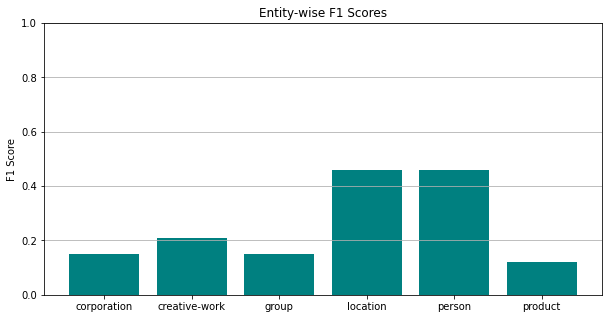

In [39]:
import matplotlib.pyplot as plt
entity_types = ['corporation', 'creative-work', 'group', 'location', 'person', 'product']
f1s = [0.15, 0.21, 0.15, 0.46, 0.46, 0.12] 
plt.figure(figsize=(10, 5))
plt.bar(entity_types, f1s, color='teal')
plt.ylabel("F1 Score")
plt.title("Entity-wise F1 Scores")
plt.grid(True, axis='y')
plt.ylim(0, 1)
plt.show()

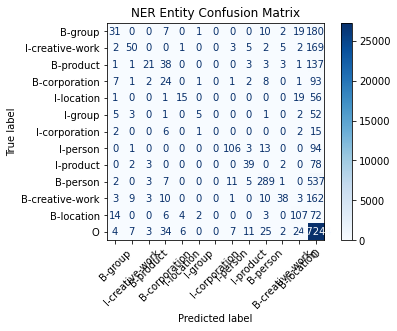

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
all_true = sum(true_labels, [])
all_pred = sum(true_predictions, [])
labels_to_display = list(set(all_true + all_pred))
cm = confusion_matrix(all_true, all_pred, labels=labels_to_display)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_to_display)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("NER Entity Confusion Matrix")
plt.show()